# Cancer Classification

In [3]:
import jax.numpy as np
import numpy as onp
import jax
from matplotlib import pyplot as plt
import pandas as pd
from jax.lib import xla_bridge
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import  train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import seaborn as sns
import ADAMLL as ada
from ADAMLL.activations import sigmoid, relu, eye, tanh


print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)

jax backend gpu


## Data

In [4]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)

print("X_train shape {}".format(X_train.shape))
print("y_train shape {}".format(y_train.shape))
print("X_test shape {}".format(X_test.shape))
print("y_test shape {}".format(y_test.shape))





X_train shape (426, 30)
y_train shape (426, 1)
X_test shape (143, 30)
y_test shape (143, 1)


### Plot data


malignent shape:  (212, 30)
benign shape:  (357, 30)


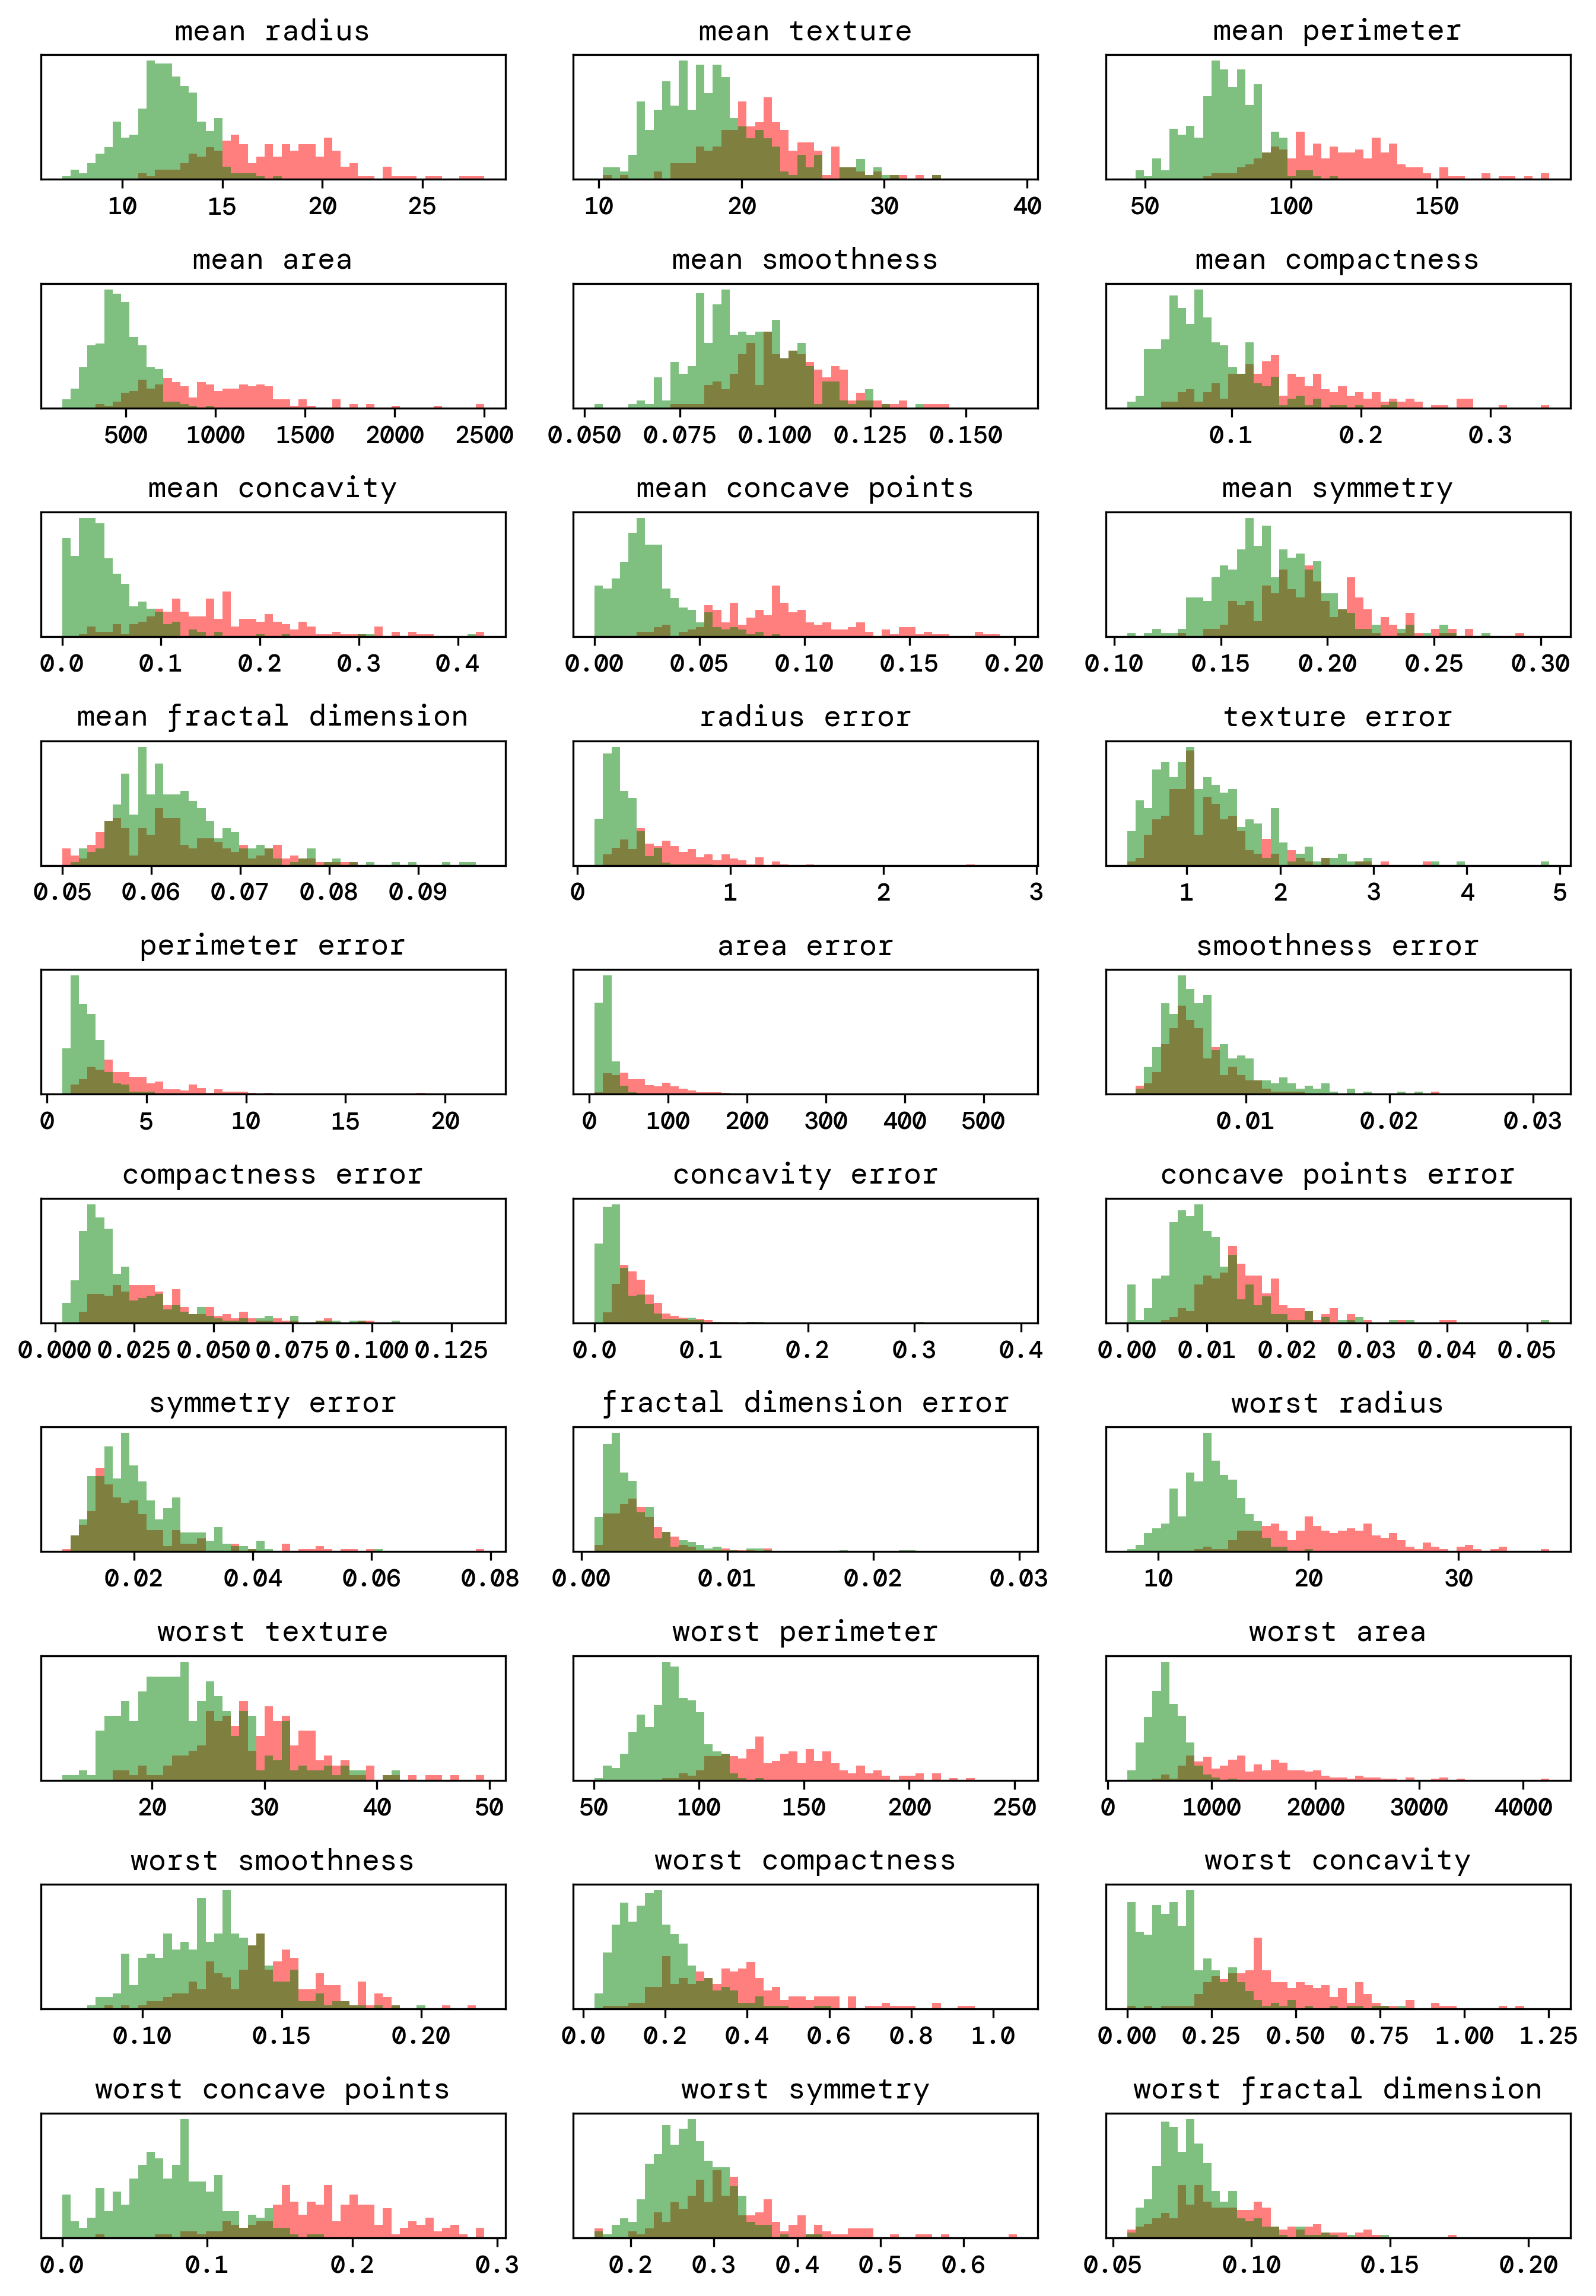

In [5]:
fig, axes = plt.subplots(10,3, figsize=(9, 13))
malignant = cancer.data[cancer.target==0]
benign = cancer.data[cancer.target==1]
print("malignent shape: ",malignant.shape)
print("benign shape: ",benign.shape)
ax = axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color='r', alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color='g', alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
fig.tight_layout()
plt.savefig("../runsAndFigures/feature_histogram.png",bbox_inches='tight')
plt.show()

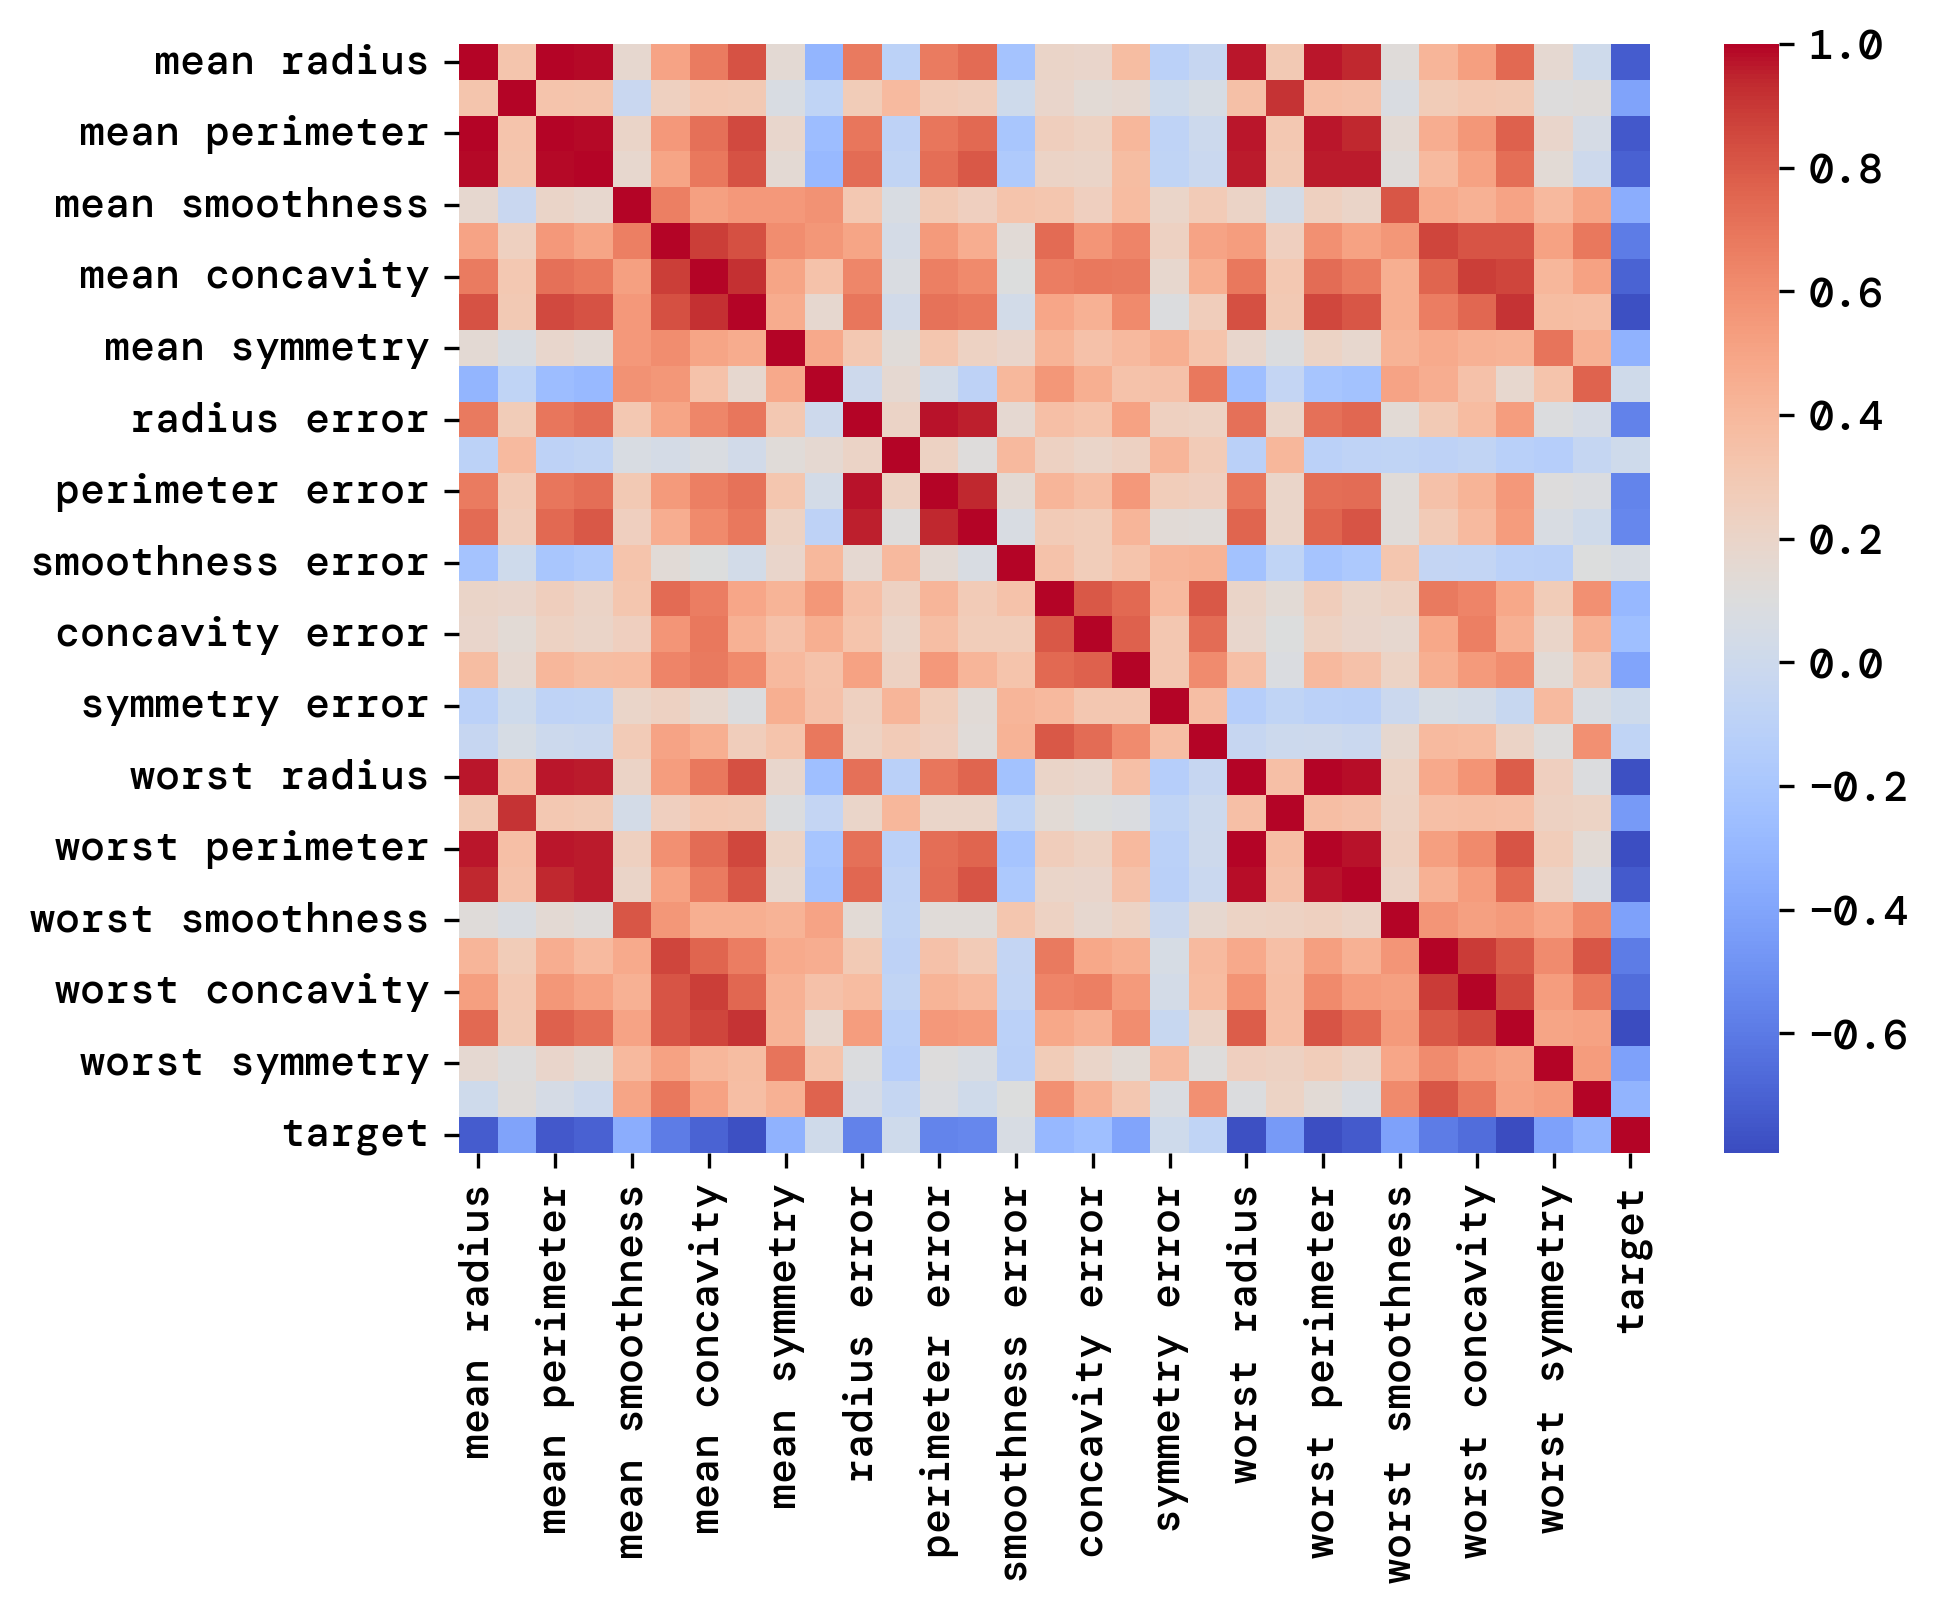

In [4]:
# correlation matrix
cancer_df = pd.DataFrame(cancer.data,columns=cancer.feature_names)
cancer_df["target"] = cancer.target
corr = cancer_df.corr()
plt.figure()
sns.heatmap(corr,cmap="coolwarm")
plt.savefig("../runsAndFigures/feature_correlation.png",bbox_inches='tight')
plt.show()

## Feature Selection

In [31]:

#Select features relevant to classification (texture,perimeter,compactness and symmetery) 
#and add to input matrix


# temp1=np.reshape(x[:,1],(len(x[:,1]),1))
# temp2=np.reshape(x[:,2],(len(x[:,2]),1))
# X=np.hstack((temp1,temp2))      
# temp=np.reshape(x[:,5],(len(x[:,5]),1))
# X=np.hstack((X,temp))       
# temp=np.reshape(x[:,8],(len(x[:,8]),1))
# X=np.hstack((X,temp))       

# X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2) #Split data into training and test sets

# y_train=to_categorical(y_train)     #Convert labels to categorical when using categorical cross entropy
# y_test=to_categorical(y_test)

# del temp1,temp2,temp

# Analysis

In [11]:

# Define tunable parameters"

                             #
tol = 0.001

# optimizer parameters
gamma = 0.9
eta = 0.01
epochs = 200
alpha = 0.0001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

kfold = KFold(n_splits=6)

def cross_val(X_train, y_train, model, kfold, batch_size=None, give_loss=False ):
    k = 0
    score = onp.zeros(kfold.n_splits)
    for train_ind, test_ind in kfold.split(X_train):
        if give_loss == True: 
            loss, _ = model.fit( X_train[train_ind], y_train[train_ind], batch_size=batch_size, X_val=
                                X_train[test_ind], t_val=y_train[test_ind])
        else:
            loss, _ =model.fit( X_train[train_ind], y_train[train_ind], batch_size=batch_size)
        score[k] = ada.accuracy(model.classify(X_train[test_ind]), y_train[test_ind])
        k += 1
    return score.mean(), score.std(), loss



### Momentum and learning rate

In [44]:
gammas = [0.1, 0.5, 0.9, 0.99]              # 0.9 works well
etas=[0.1, 0.01, 0.001, 0.0001]             # 0.1 works well 
scores_lr_gamma = onp.zeros((len(etas), len(gammas)))

for i, e in enumerate(etas):
    for j, g in enumerate(gammas):
        network = ada.NN.Model([[1, sigmoid]], e,epochs,tol, 'sgd', alpha, g, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
        mean, std = cross_val(X_train, y_train, network, kfold )
        scores_lr_gamma[i,j] = mean
    print(ada.progress_bar(i, len(gammas)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%


## Lambdas

In [47]:
alphas = [0, 0.0001, 0.001, 0.01, 0.1]
scores_alpha = onp.zeros((len(alphas), 2) )
for i, a in enumerate(alphas):
    network = ada.NN.Model([[1, sigmoid]], eta,epochs,tol, 'sgd', a, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
    mean, var = cross_val(X_train, y_train, network, kfold)
    scores_alpha[i] = [mean, var] 
    print(ada.progress_bar(i, len(alphas)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [--->                ] 20%
Training stopped after 199 epochs                                     Progress: [------->            ] 40%
Training stopped after 199 epochs                                     Progress: [----------->        ] 60%
Training stopped after 199 epochs                                     Progress: [--------------->    ] 80%


## Batches

In [48]:
batch_sizes = [ 50, 100, 500 ]
score_batches = onp.zeros((len(batch_sizes), 2) )
for i, batch_size in enumerate(batch_sizes):
    network = ada.NN.Model([[1, sigmoid]], eta ,epochs,tol, 'sgd', alpha, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
    mean, var = cross_val(X_train, y_train, network, kfold, batch_size=batch_size)
    score_batches[i] = [mean, var]
    print(ada.progress_bar(i, len(batch_sizes)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [----->              ] 33%
Training stopped after 199 epochs                                     Progress: [------------>       ] 66%


### Adam vs RMSProp vs AdaGrad

In [49]:
optimizer_names = ['adam', 'adagrad', 'rmsprop', 'sgd']
scores_optimizer = onp.zeros((len(optimizer_names), 2) )
for i, optimizer in enumerate(optimizer_names):
    network = ada.NN.Model([[1, sigmoid]], eta,epochs,tol, optimizer, alpha, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE )
    mean, var = cross_val(X_train, y_train, network, kfold)
    scores_optimizer[i] = [mean, var]
    print(ada.progress_bar(i, len(optimizer_names)))


Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%


## Multiple layers

In [56]:
n_layers = [1,2, 3, 4, 5]
n_nodes  = [2, 3, 5, 10]
epochs = 300

scores_layers_nodes = onp.zeros((len(n_layers), len(n_nodes)) )
for i, n_layer in enumerate(n_layers):
    for j, n_node in enumerate(n_nodes):
        model =  ada.NN.Model([[n_node,sigmoid]]*n_layer + [[1,sigmoid]], eta, epochs, tol, "sgd", alpha, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE) 
        mean, var = cross_val(X_train, y_train, model, kfold)
        scores_layers_nodes[i, j] = mean 
        print(ada.progress_bar(i*len(n_nodes) + j, len(n_layers)*len(n_nodes)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [>                   ] 5%
Training stopped after 199 epochs                                     Progress: [->                  ] 10%
Training stopped after 199 epochs                                     Progress: [-->                 ] 15%
Training stopped after 199 epochs                                     Progress: [--->                ] 20%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [----->              ] 30%
Training stopped after 199 epochs                                     Progress: [------>             ] 35%
Training stopped after 199 epochs                                     Progress: [------->            ] 40%
Training stopped after 199 epochs      

## Activation functions

In [60]:
acitvs = [relu, sigmoid, tanh]
epochs = 300

scores_activs = onp.zeros((len(acitvs), 2) )
for i, activ in enumerate(acitvs):
    model =  ada.NN.Model([[5,activ],[1,sigmoid]], eta, epochs, tol, "sgd", alpha, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE) 
    mean, var = cross_val(X_train, y_train, model, kfold)
    scores_activs[i] = [mean, var]
    print(ada.progress_bar(i, len(acitvs)))

Training stopped after 299 epochs                                     Progress: [>                   ] 0%
Training stopped after 299 epochs                                     Progress: [----->              ] 33%
Training stopped after 299 epochs                                     Progress: [------------>       ] 66%


## Plot

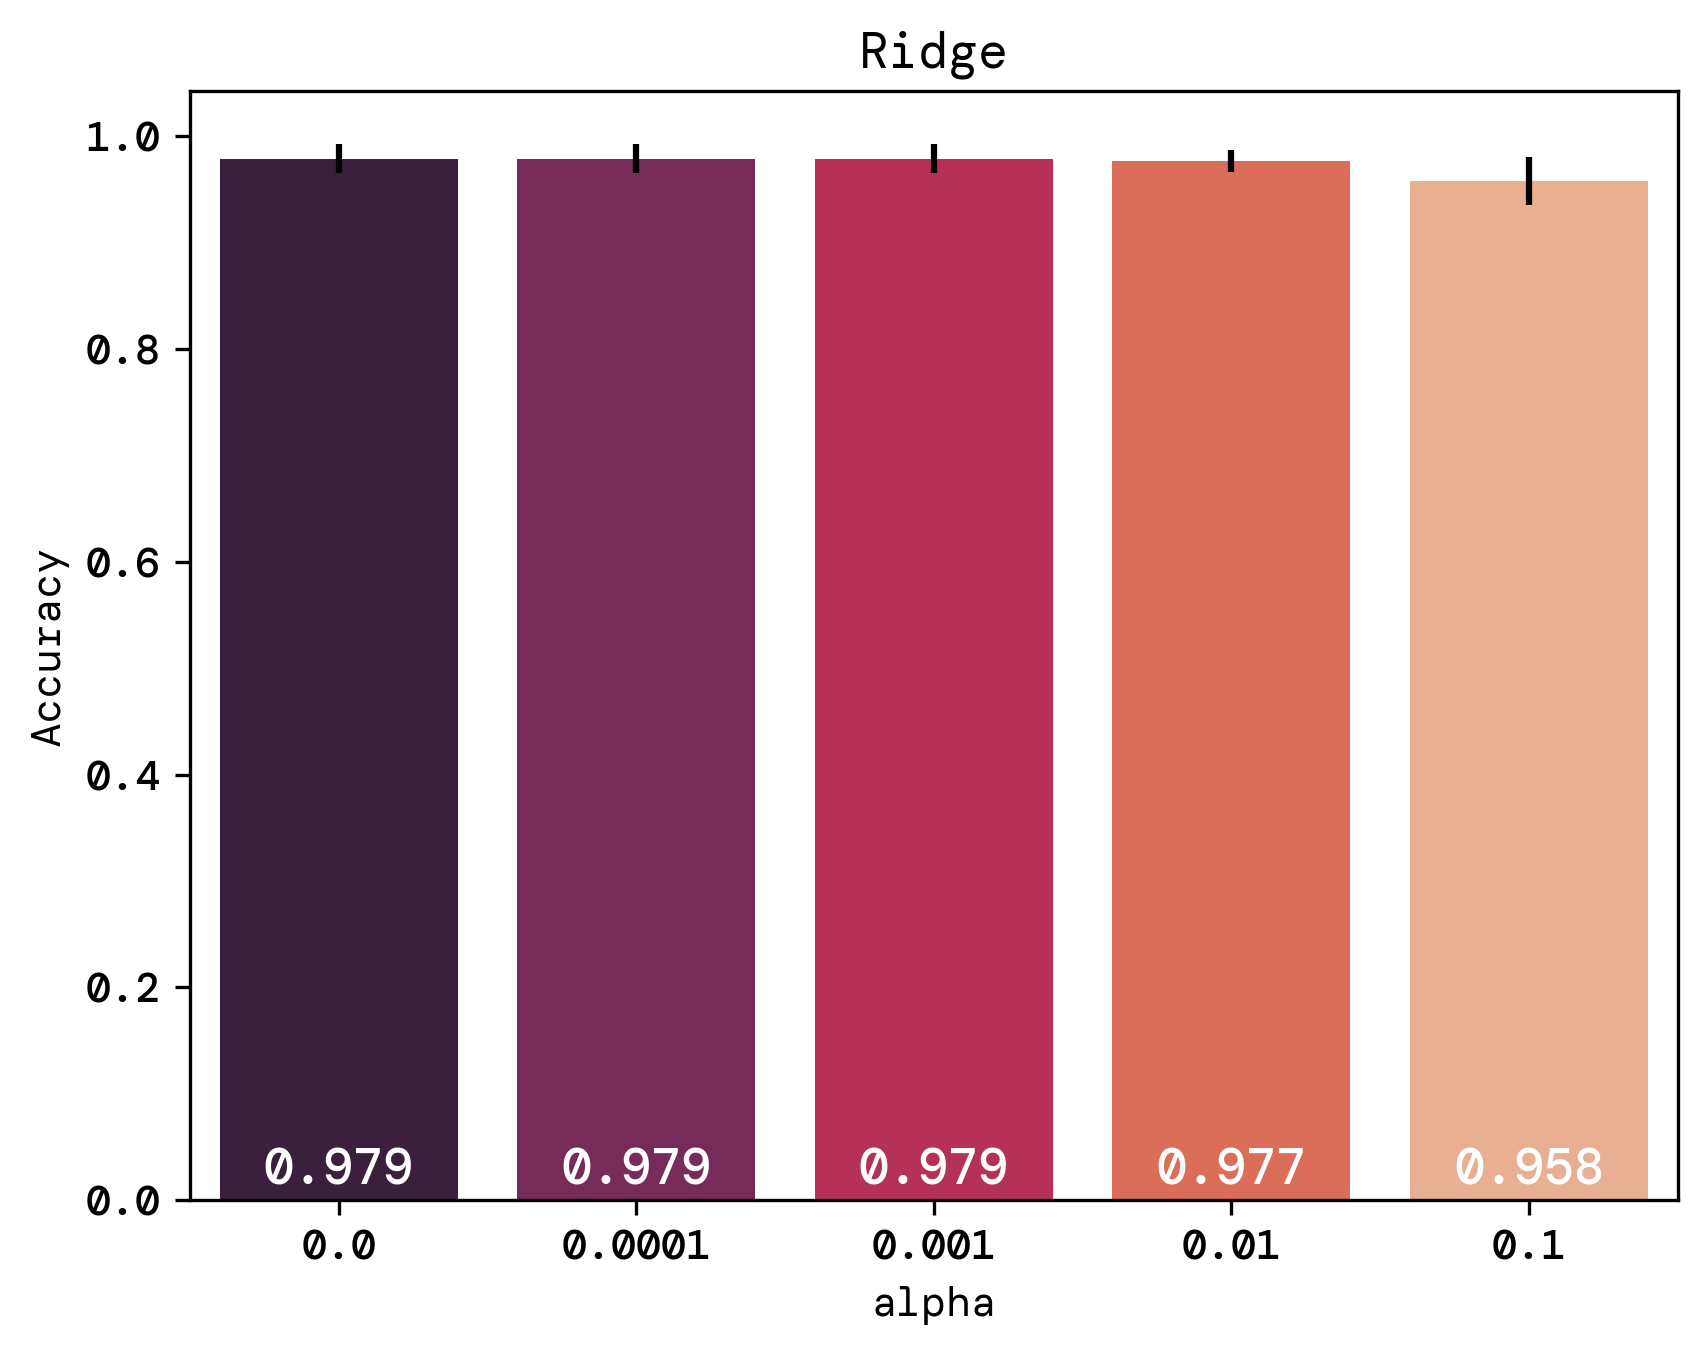

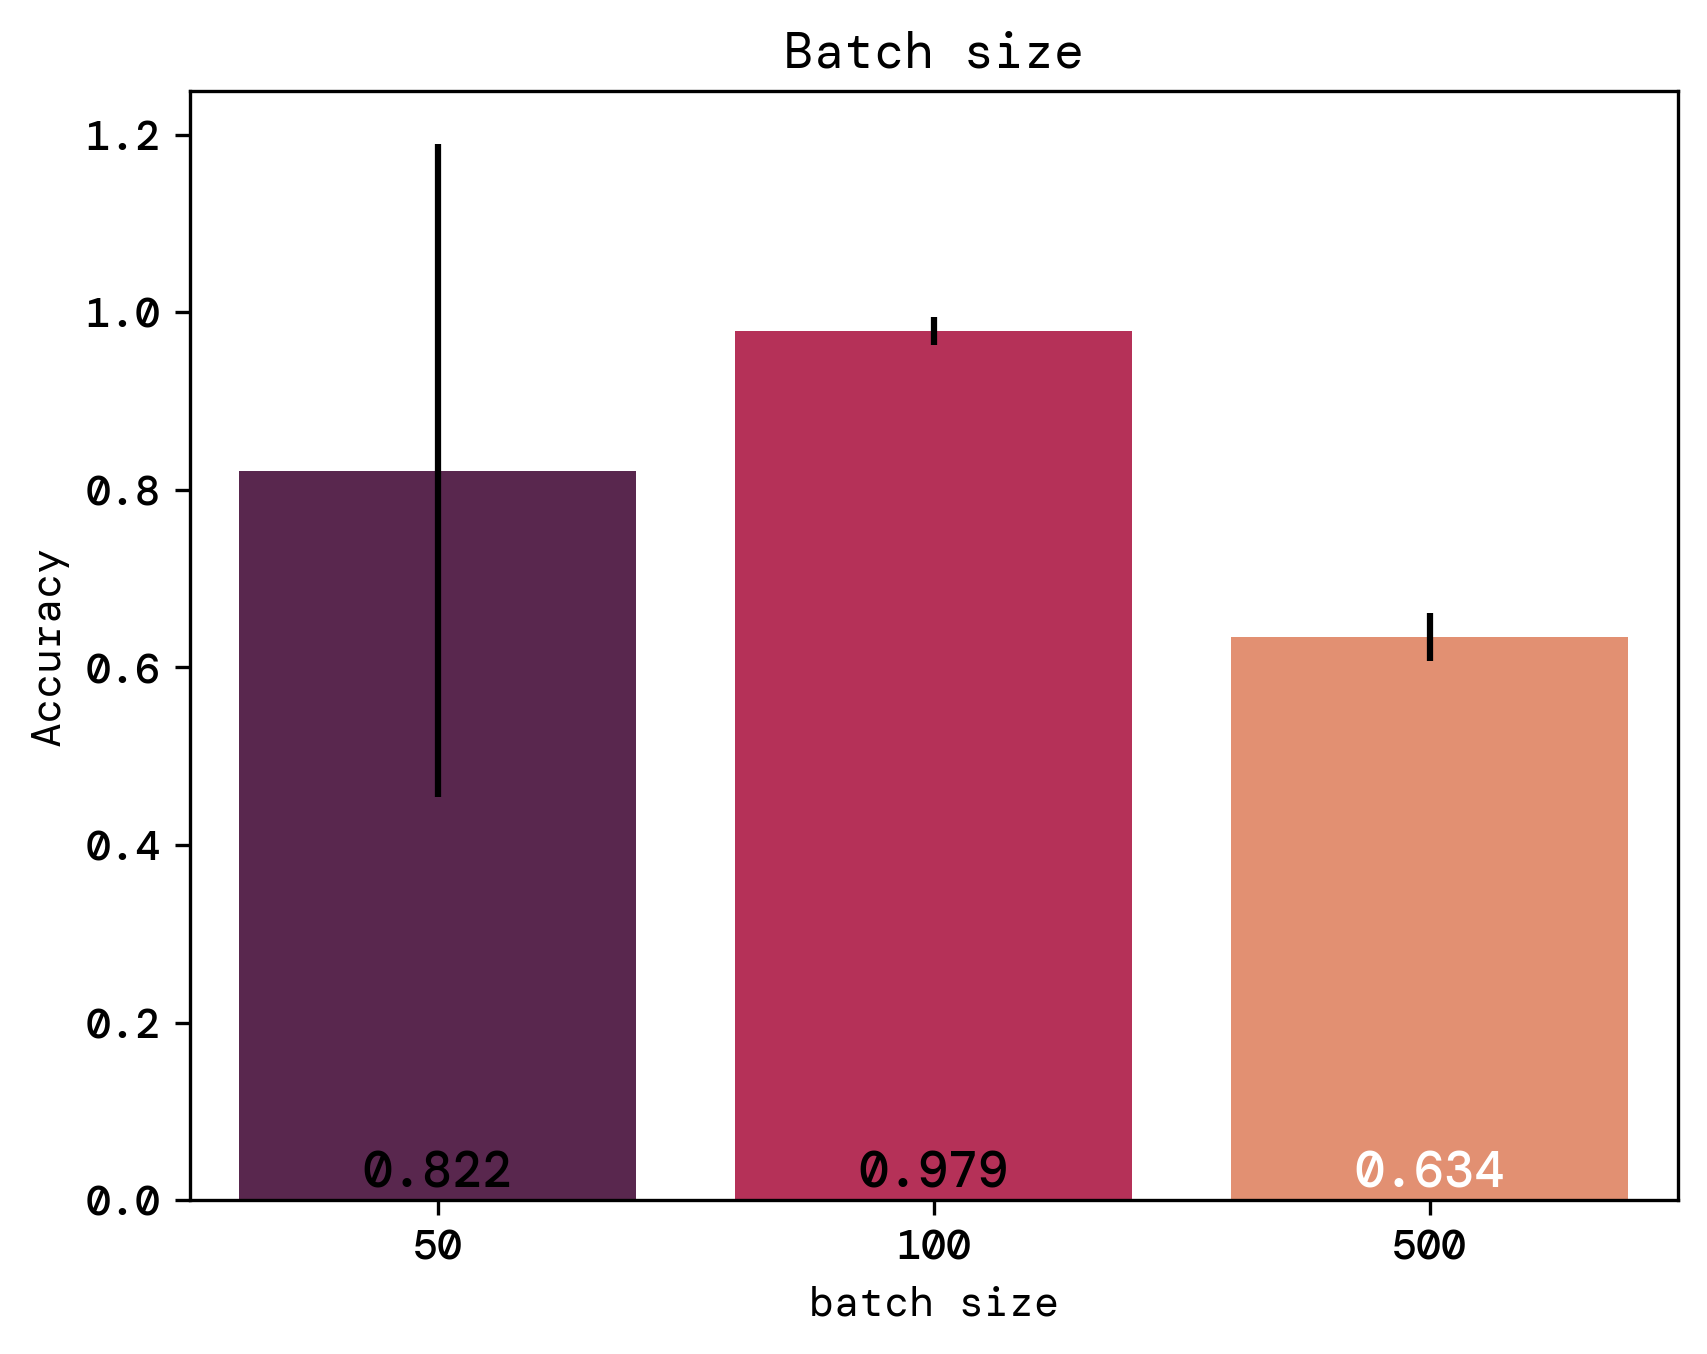

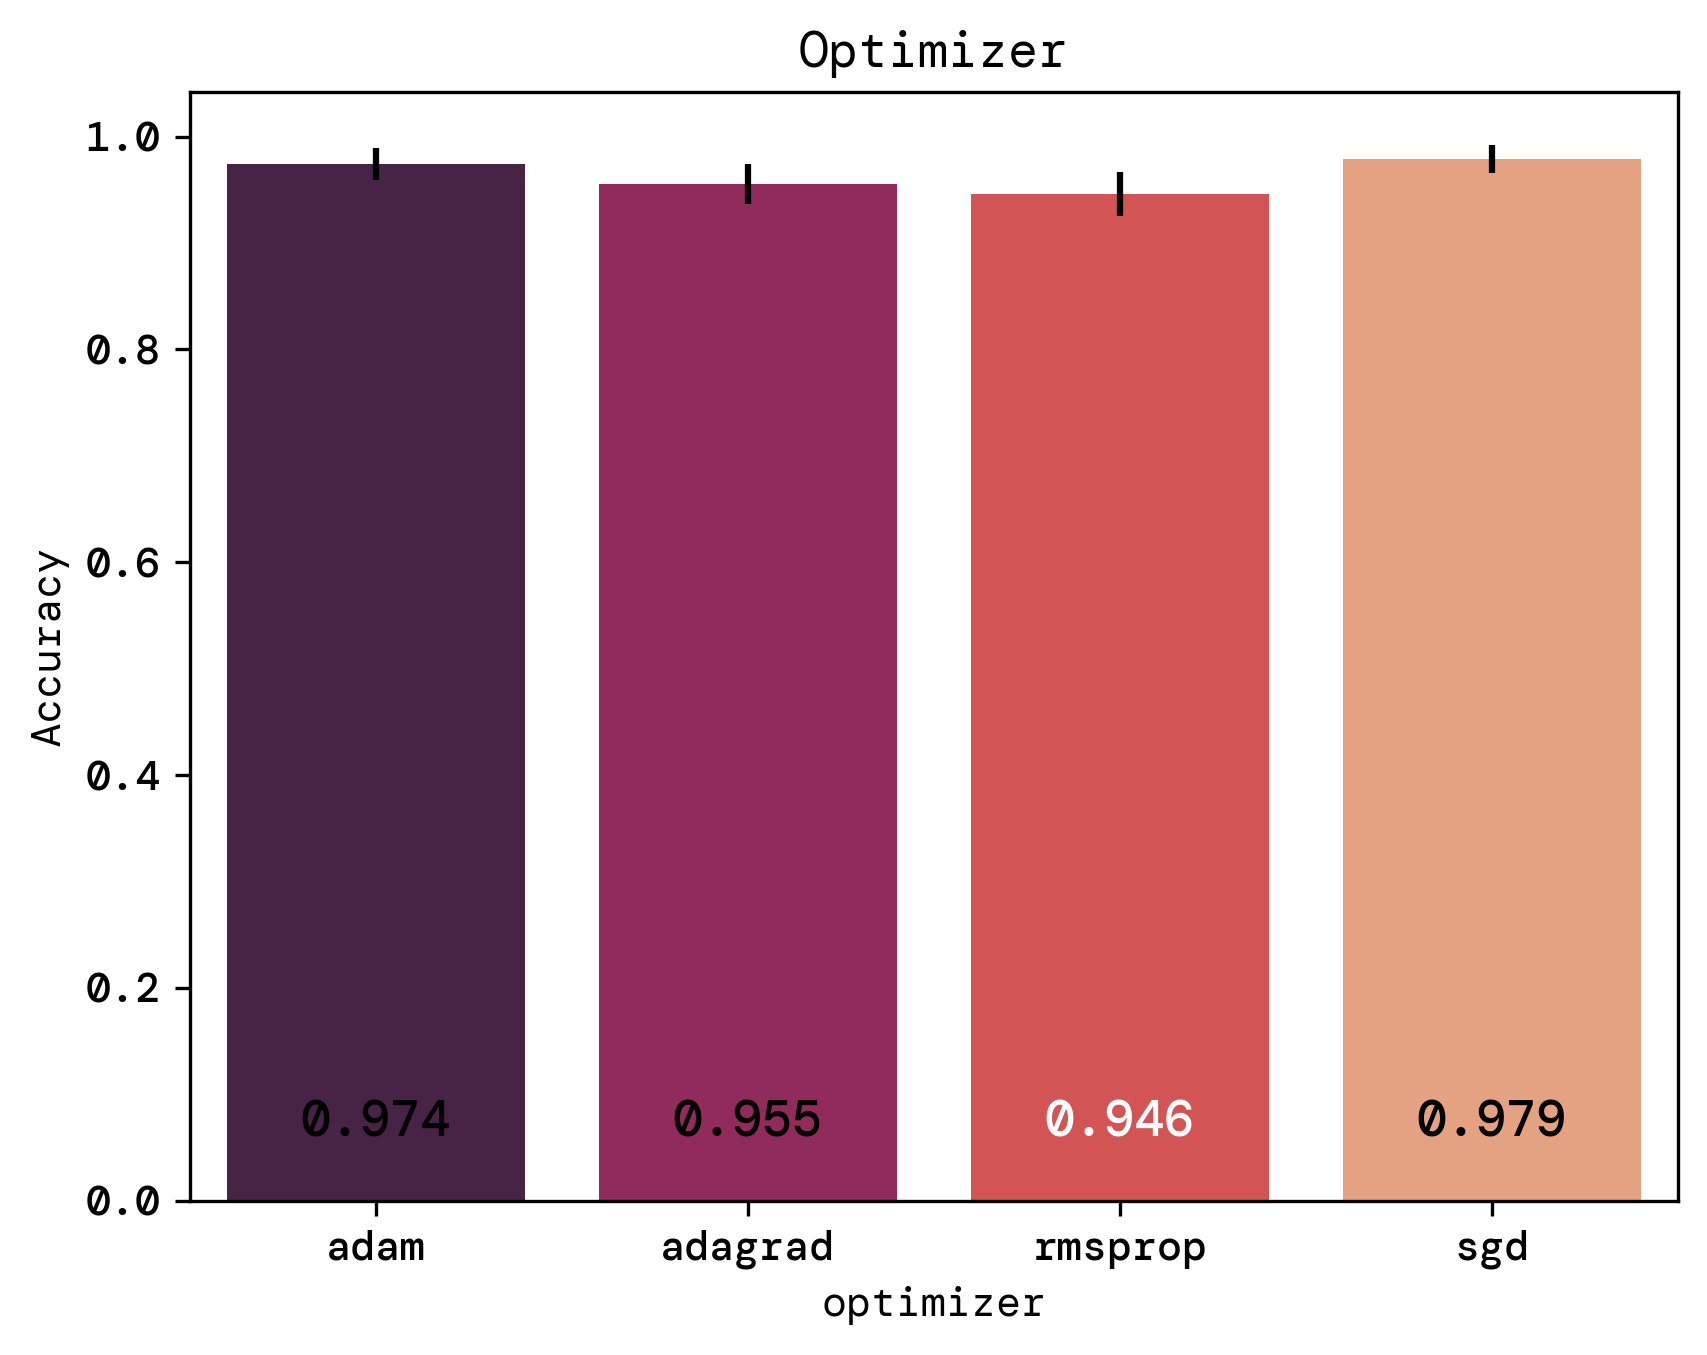

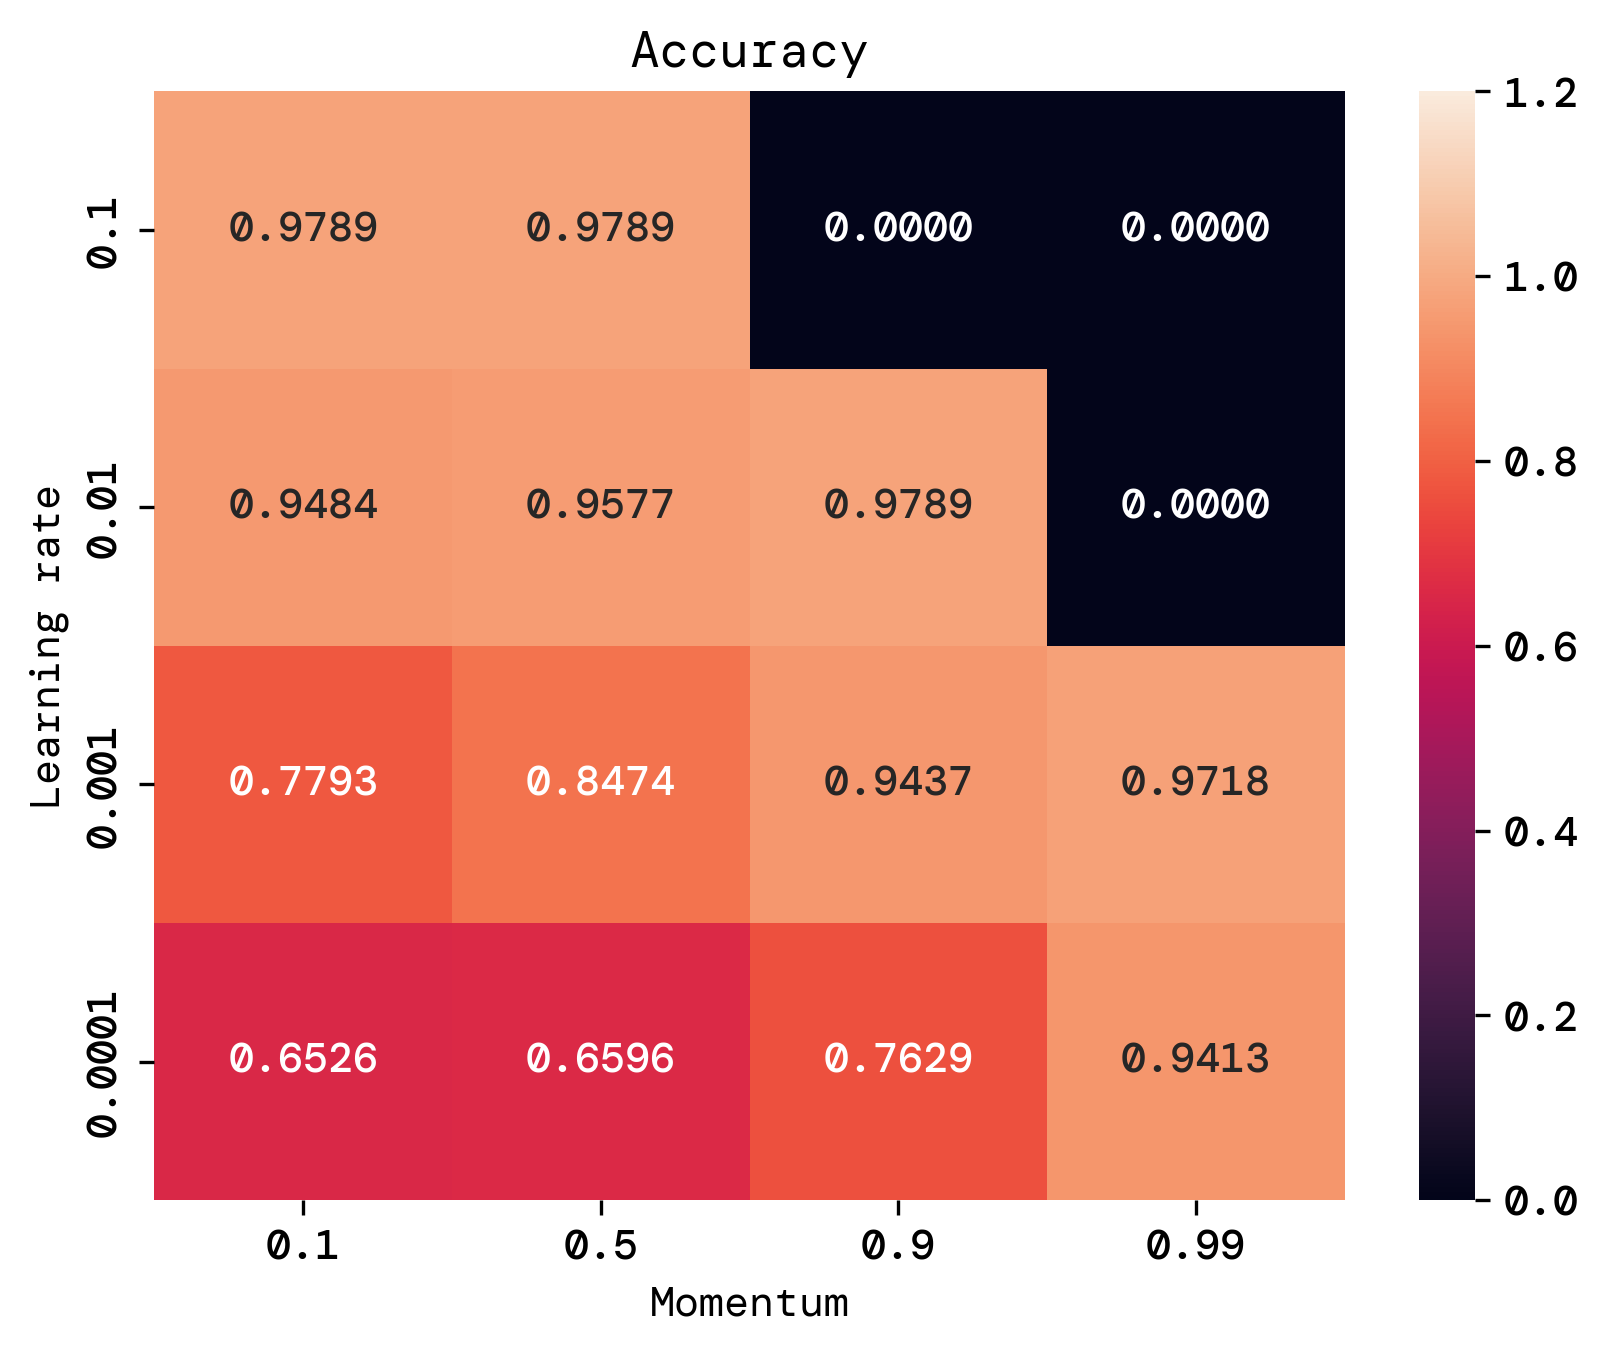

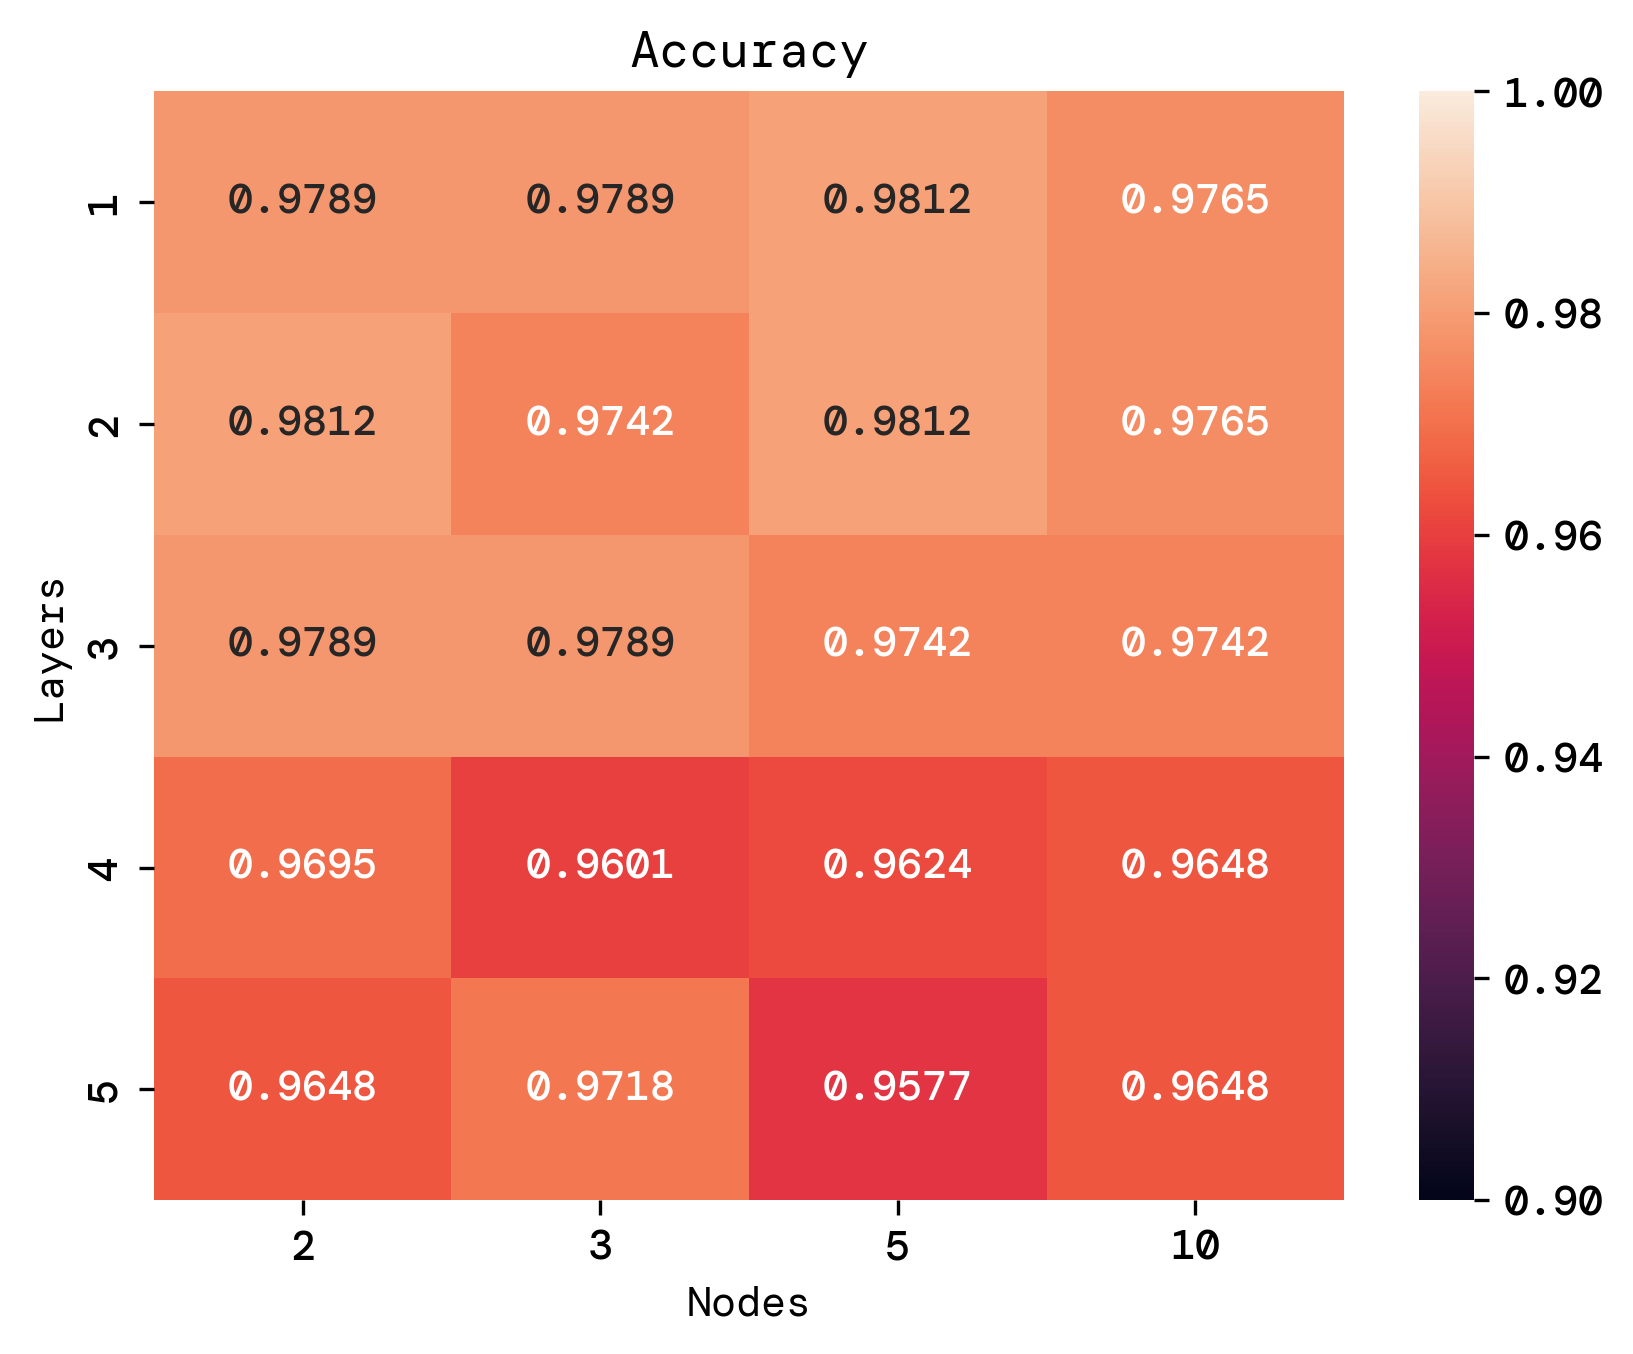

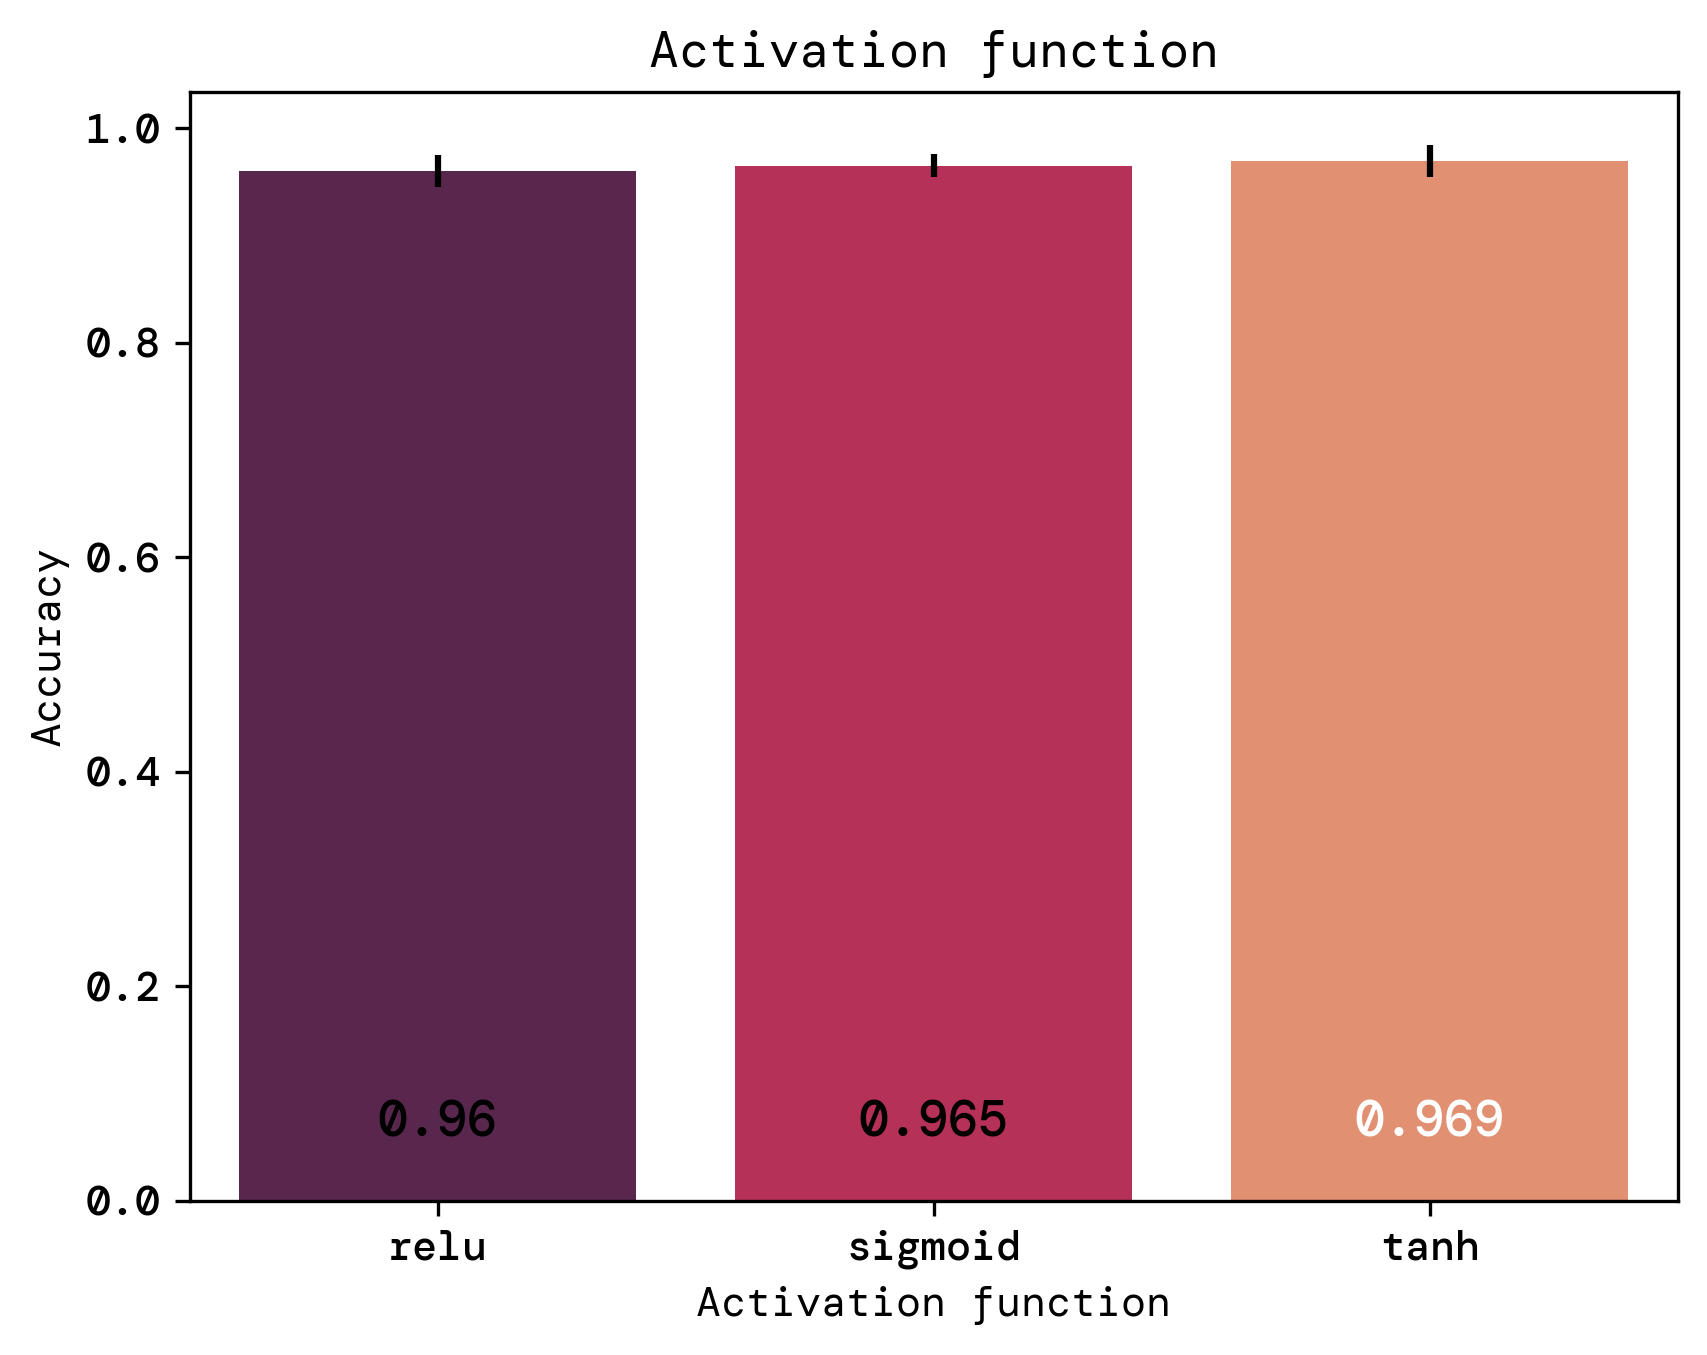

In [61]:

ax = sns.barplot(x=alphas, y=scores_alpha[:,0], palette="rocket", yerr=scores_alpha[:,1])
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Ridge")
# ax.set_ylim(0.01, 0.05)
ax.text(0, 0.015, f"{scores_alpha[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{scores_alpha[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{scores_alpha[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{scores_alpha[3,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(4, 0.015, f"{scores_alpha[4,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/accuracy_alpha.png",bbox_inches='tight')
plt.show()
plt.figure()


ax = sns.barplot(x=batch_sizes, y=score_batches[:,0], yerr=score_batches[:,1], palette="rocket")
ax.set_xlabel("batch size")
ax.set_ylabel("Accuracy")
ax.set_title("Batch size")
ax.text(0, 0.015, f"{score_batches[0,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(1, 0.015, f"{score_batches[1,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(2, 0.015, f"{score_batches[2,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/accuracy_batch.png",bbox_inches='tight')
plt.show()


plt.figure()
ax = sns.barplot(x=optimizer_names, y=scores_optimizer[:,0], yerr=scores_optimizer[:,1], palette="rocket")
ax.set_xlabel("optimizer")
ax.set_ylabel("Accuracy")
ax.set_title("Optimizer")
# ax.set_ylim(0.01, 0.12)
ax.text(0, 0.06, f"{scores_optimizer[0,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(1, 0.06, f"{scores_optimizer[1,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(2, 0.06, f"{scores_optimizer[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.06, f"{scores_optimizer[3,0]:.3}", ha='center',  fontsize=12, color='black')
plt.savefig("../runsAndFigures/accuracy_optimizer.png",bbox_inches='tight')
plt.show()



plt.figure()
ax = sns.heatmap(scores_lr_gamma, annot=True, fmt=".4f", cmap="rocket", vmax=1.2, vmin=0.0)
ax.set_title("Accuracy")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.savefig("../runsAndFigures/accuracy_lr_gamma.png",bbox_inches='tight')
plt.show()


plt.figure()
ax = sns.heatmap(scores_layers_nodes, annot=True, fmt=".4f", cmap="rocket", vmax=1.0, vmin=0.9)
ax.set_title("Accuracy")
ax.set_xlabel("Nodes")
ax.set_xticklabels(n_nodes)
ax.set_ylabel("Layers")
ax.set_yticklabels(n_layers)
plt.savefig("../runsAndFigures/accuracy_layers_nodes.png",bbox_inches='tight')
plt.show()

plt.figure()
activs_names = ["relu", "sigmoid", "tanh"]
ax = sns.barplot(x=activs_names, y=scores_activs[:,0], yerr=scores_activs[:,1], palette="rocket")
ax.set_xlabel("Activation function")
ax.set_ylabel("Accuracy")
ax.set_title("Activation function")
# ax.set_ylim(0.01, 0.125)
ax.text(0, 0.06, f"{scores_activs[0,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(1, 0.06, f"{scores_activs[1,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(2, 0.06, f"{scores_activs[2,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/accuracy_activ.png",bbox_inches='tight')
plt.show()


## Final Evaluation

### fine-tuning

Training stopped after 149 epochs                                     Accuracy:  0.9671361247698466


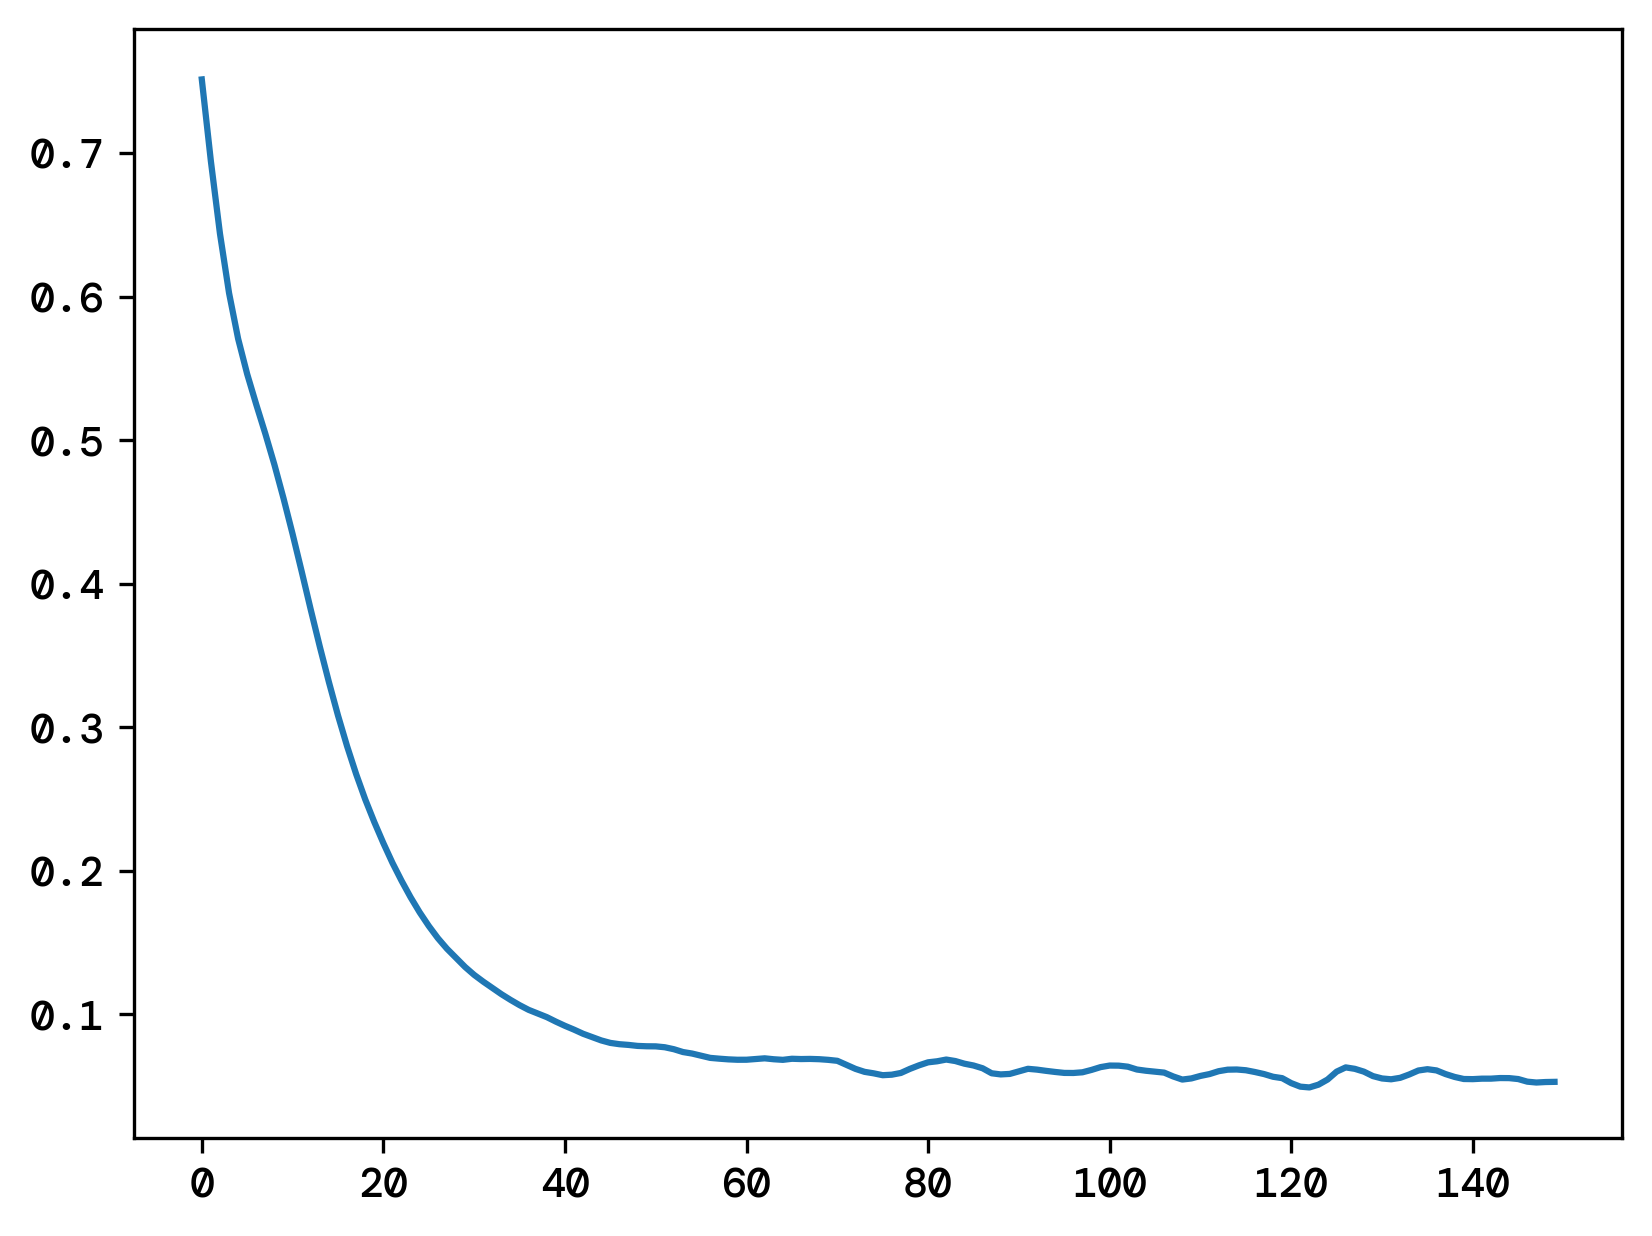

In [14]:
# manual fine tuning
# best hyperparameters
eta = 0.01
epochs = 150
tol = 0.001
alpha = 0.0001
gamma = 0.9
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999
batch_size = 100



model = ada.NN.Model([[2,sigmoid],[2,tanh],[1,sigmoid]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE)

mean, var, loss = cross_val(X_train, y_train, model, kfold, batch_size=batch_size, give_loss=True)

# matrix = ada.confusion_matrix(model.classify(X_test), y_test)
# print(matrix)
print("Accuracy: ", mean)
plt.plot(loss)

In [13]:
print(ada.accuracy(model.classify(X_test), y_test))

0.951049


## Comparing with TensorFlow

5/5 [==============================] - 0s 2ms/step - loss: 3.8202e-04 - accuracy: 0.7972


5/5 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.3706


5/5 [==============================] - 0s 3ms/step - loss: 2.0368 - accuracy: 0.3706


5/5 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.3706


TypeError: object of type 'int' has no len()

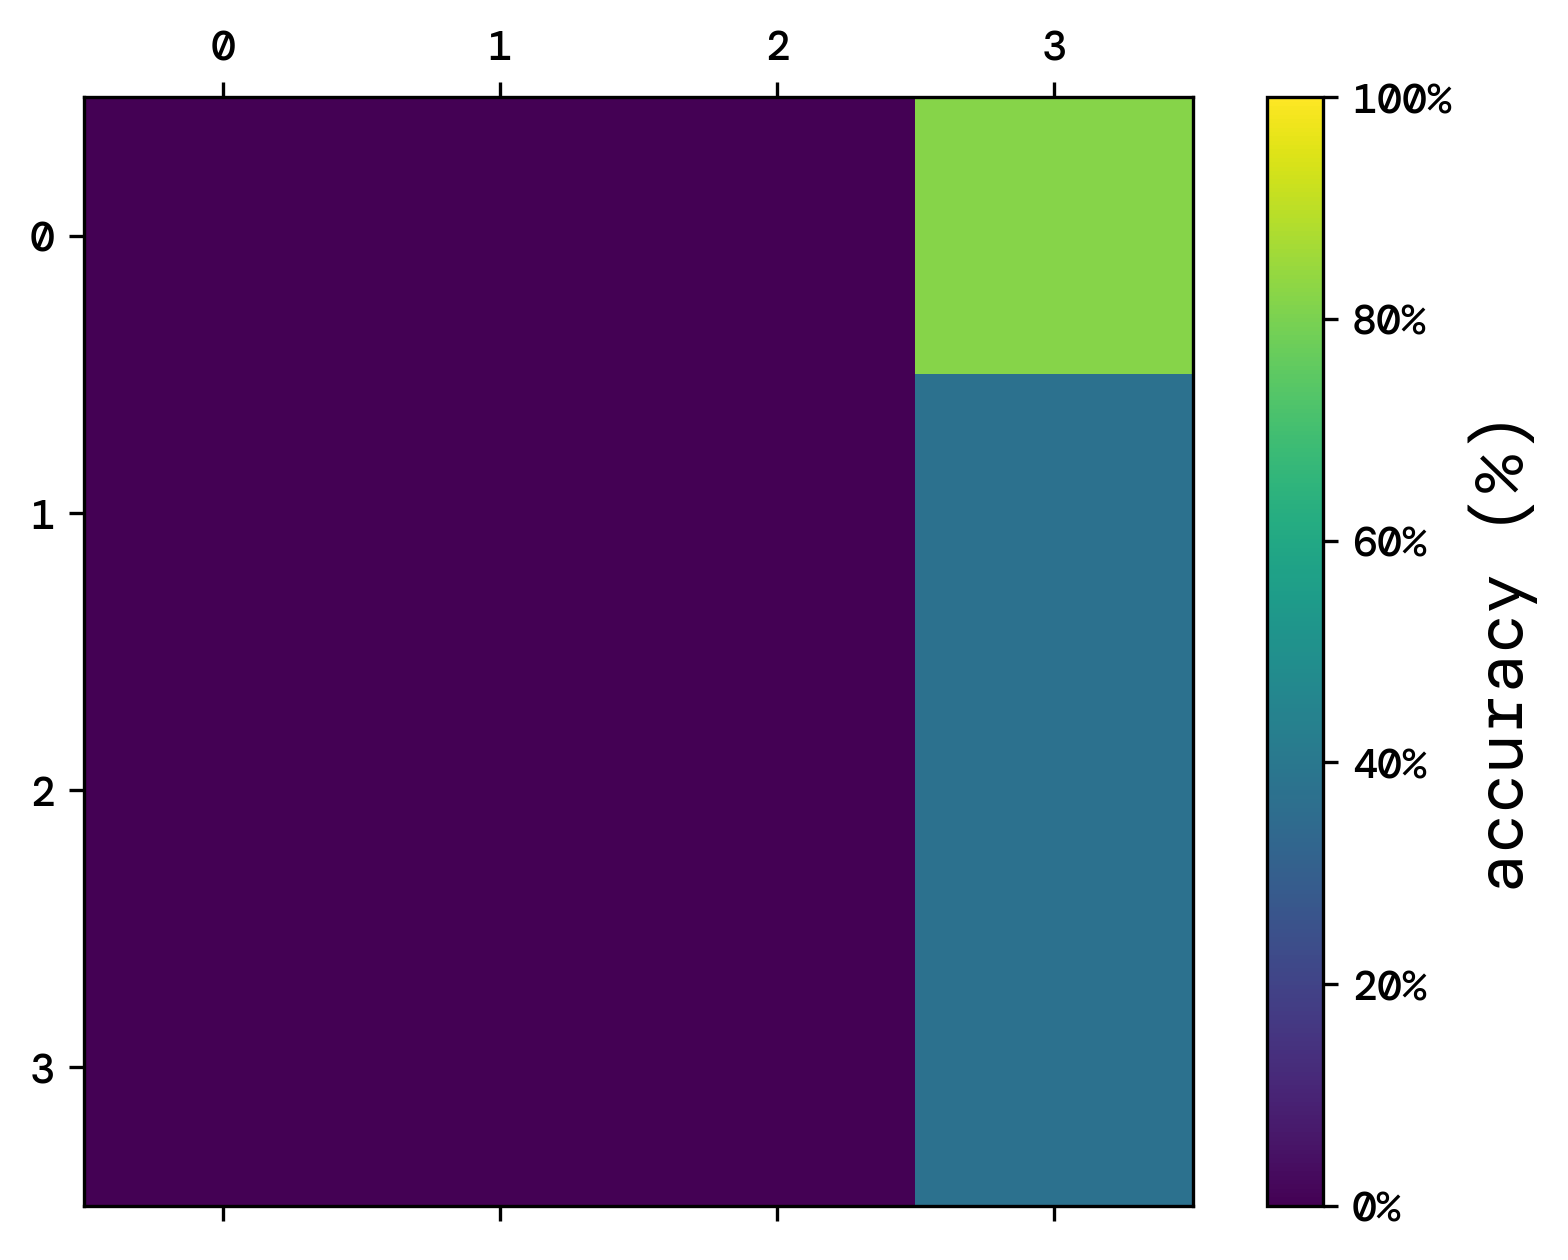

In [40]:
#Copied from the fys-stk4155 repository: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html#the-breast-cancer-data-now-with-keras
import numpy as onp
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
import pickle
import os 

X_train = onp.asarray(X_train)
X_test = onp.asarray(X_test)
y_train = onp.asarray(y_train).reshape(-1,1)
y_test = onp.asarray(y_test).reshape(-1,1)

                      #Number of samples per gradient update



"""Define function to return Deep Neural Network model"""

def NN_model(inputsize,n_layers,n_neuron,eta,lamda):
    model=Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda),input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda)))
    model.add(Dense(1,activation='sigmoid'))  #2 outputs - ordered and disordered (softmax for prob)
    sgd=optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
    return model

    
Train_accuracy=onp.zeros((len(n_neuron),len(etas)))      #Define matrices to store accuracy scores as a function
Test_accuracy=onp.zeros((len(n_neuron),len(etas)))       #of learning rate and number of hidden neurons for 

for i in range(len(n_neuron)):     #run loops over hidden neurons and learning rates to calculate 
    DNN_model=NN_model(X_train.shape[1],2,n_neuron[i],0.01, 0.0001)
    DNN_model.fit(X_train,y_train,epochs=100,batch_size=batch_size,verbose=0)
    Train_accuracy[i,j]=DNN_model.evaluate(X_train,y_train)[1]
    Test_accuracy[i,j]=DNN_model.evaluate(X_test,y_test)[1]
               

def plot_data(x,y,data,title=None):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()

    plt.show()
    
plot_data(eta,n_neuron,Train_accuracy, 'training')
plot_data(eta,n_neuron,Test_accuracy, 'testing')

## Comparing with SKLearn

In [ ]:
#Copied from the fys-stk4155 repository: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter4.html
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))